In [16]:
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
%matplotlib inline

import pandas.tseries
converter.register()

import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize':2})

import rdtools

/Users/mkim/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  if __name__ == '__main__':


In [41]:
TIMEZONE = 'Australia/North'
LATITUDE = -23.762028
LONGITUDE = 133.874886
TILT = 20
AZIMUTH = 0
TEMP_MODEL = 'open_rack_cell_polymerback'
PDC = 5100.0
TEMPCO = -0.005

In [21]:
imported_df = pd.read_csv('84-Site_12-BP-Solar.csv')

In [38]:
df = imported_df.rename(columns = {
    '12 BP Solar - Active Power (kW)': 'power',
    '12 BP Solar - Wind Speed (m/s)': 'wind',
    '12 BP Solar - Weather Temperature Celsius (\xc2\xb0C)': 'Tamb',
    '12 BP Solar - Global Horizontal Radiation (W/m\xc2\xb2)': 'ghi',
    '12 BP Solar - Diffuse Horizontal Radiation (W/m\xc2\xb2)': 'dhi'
})

df.index = pd.to_datetime(df.Timestamp)
df.index = df.index.tz_localize(TIMEZONE)

df = df['2008-11-11':'2017-05-15']

df['power'] = df['power'] * 1000

frequency = pd.infer_freq(df.index[:10])
df = df.resample(frequency).median()

df['energy'] = df.power * pd.to_timedelta(df.power.index.freq).total_seconds()/(3600.0)

# Irradiance calculation
loc = pvlib.location.Location(LATITUDE, LONGITUDE, tz=TIMEZONE)
sun = loc.get_solarposition(df.index)

sky = pvlib.irradiance.isotropic(TILT, df.dhi)
df['dni'] = (df['ghi'] - df['dhi'])/np.cos(np.deg2rad(sun.zenith))
beam = pvlib.irradiance.beam_component(TILT, AZIMUTH, sun.zenith, sun.azimuth, df['dni'])
df['poa'] = beam + sky

df_temp = pvlib.pvsystem.sapm_celltemp(df.poa, df.wind, df.Tamb, model=TEMP_MODEL)
df['Tcell'] = df_temp['temp_cell']

df.head()

,12 BP Solar - Active Energy Delivered-Received (kWh),12 BP Solar - Current Phase Average (A),power,12 BP Solar - Performance Ratio (%),wind,Tamb,12 BP Solar - Weather Relative Humidity (%),ghi,dhi,12 BP Solar - Wind Direction (Degrees),12 BP Solar - Weather Daily Rainfall (mm),energy,dni,poa,Tcell
Timestamp,,,,,,,,,,,,,,,
2008-11-11 00:00:00+09:30,516.0,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-11-11 00:05:00+09:30,516.0,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-11-11 00:10:00+09:30,516.0,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-11-11 00:15:00+09:30,516.0,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-11-11 00:20:00+09:30,516.0,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


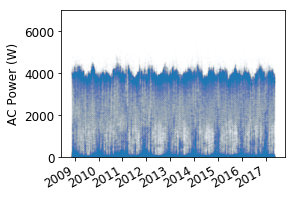

In [39]:
# plot the AC power time series
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(df.index, df.power, 'o', alpha = 0.01)
ax.set_ylim(0,7000)
fig.autofmt_xdate()
ax.set_ylabel('AC Power (W)');

In [44]:
pvwatts_keywords = {"poa_global" : df['poa'],
                  "P_ref" : PDC,
                  "T_cell" : df['Tcell'],
                  "G_ref" : 1000,
                  "T_ref": 25,
                  "gamma_pdc" : TEMPCO}

normalized, insolation = rdtools.normalize_with_pvwatts(df['energy'], pvwatts_keywords)

df['normalized'] = normalized
df['insolation'] = insolation

df.head()

,12 BP Solar - Active Energy Delivered-Received (kWh),12 BP Solar - Current Phase Average (A),power,12 BP Solar - Performance Ratio (%),wind,Tamb,12 BP Solar - Weather Relative Humidity (%),ghi,dhi,12 BP Solar - Wind Direction (Degrees),12 BP Solar - Weather Daily Rainfall (mm),energy,dni,poa,Tcell,normalized,insolation
Timestamp,,,,,,,,,,,,,,,,,
2008-11-11 00:00:00+09:30,516.0,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2008-11-11 00:05:00+09:30,516.0,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2008-11-11 00:10:00+09:30,516.0,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2008-11-11 00:15:00+09:30,516.0,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2008-11-11 00:20:00+09:30,516.0,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


Text(0,0.5,u'Normalized energy')

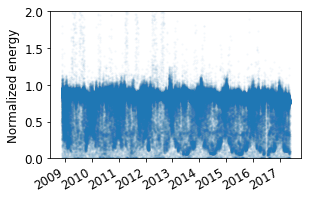

In [45]:
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy')

In [47]:
nz_mask = df['normalized'] > 0
poa_mask = rdtools.poa_filter(df['poa'])
tcell_mask = rdtools.tcell_filter(df['Tcell'])
clip_mask = rdtools.clip_filter(df['power'])

filtered_df = df[nz_mask & poa_mask & tcell_mask & clip_mask]
filtered_df = filtered_df[['insolation', 'normalized']]

filtered_df.head()

,insolation,normalized
Timestamp,,
2008-11-13 16:50:00+09:30,34.550662,0.862055
2008-11-13 16:55:00+09:30,32.860717,0.837727
2008-11-13 17:00:00+09:30,32.555132,0.828571
2008-11-13 17:05:00+09:30,30.865799,0.809388
2008-11-13 17:10:00+09:30,24.010793,0.777146


Text(0,0.5,u'Normalized energy')

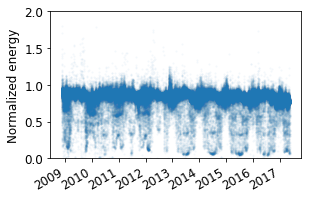

In [49]:
fig, ax = plt.subplots()
ax.plot(filtered_df.index, filtered_df.normalized, 'o', alpha = 0.05)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy')

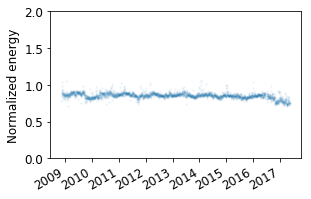

In [51]:
daily = rdtools.aggregation_insol(filtered_df.normalized, filtered_df.insolation, frequency='D')

fig, ax = plt.subplots()
ax.plot(daily.index, daily, 'o', alpha = 0.1)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

Text(0.5,0.98,u'Sensor-based degradation results')

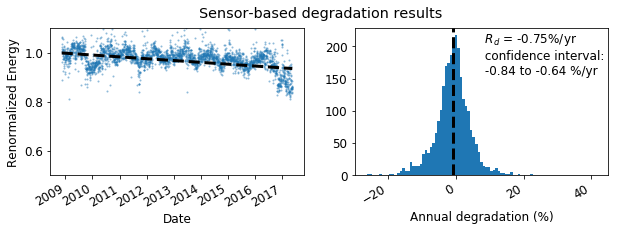

In [52]:
# Calculatig the degradation rate with the year on year method

yoy_rd, yoy_ci, yoy_info = rdtools.degradation_year_on_year(daily)

start = daily.index[0]
end = daily.index[-1]
years = (end - start).days / 365.0
yoy_values = yoy_info['YoY_values']

x = [start, end]
y = [1, 1 + (yoy_rd * years)/100]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3))
ax2.hist(yoy_values, label='YOY', bins=len(yoy_values)/40)
ax2.axvline(x=yoy_rd, color='black', linestyle='dashed', linewidth=3)
ax2.set_xlim(-30,45)
ax2.annotate( u' $R_{d}$ = %.2f%%/yr \n confidence interval: \n %.2f to %.2f %%/yr' 
             %(yoy_rd, yoy_ci[0], yoy_ci[1]),  xy=(0.5, 0.7), xycoords='axes fraction',
            bbox=dict(facecolor='white', edgecolor=None, alpha = 0))
ax2.set_xlabel('Annual degradation (%)');

ax1.plot(daily.index, daily/yoy_info['renormalizing_factor'], 'o', alpha = 0.5)
ax1.plot(x, y, 'k--', linewidth=3)
ax1.set_xlabel('Date')
ax1.set_ylabel('Renormalized Energy')
ax1.set_ylim(0.5, 1.1)
fig.autofmt_xdate()

fig.suptitle('Sensor-based degradation results')


In [53]:
print 'The P95 exceedance level is %.2f%%/yr' % yoy_info['exceedance_level']

The P95 exceedance level is -0.92%/yr


## Now trying with PVDAQ data

In [ ]:
DAQ_TIMEZONE = 'America/Los_Angeles'
DAQ_LATITUDE = 37.6478
DAQ_LONGITUDE = 121.7742
DAQ_TILT = 20
DAQ_AZIMUTH = 0
DAQ_TEMP_MODEL = 'open_rack_cell_polymerback'
DAQ_PDC = 5100.0
DAQ_TEMPCO = -0.005

NameError: name 'pytz' is not defined